# **3 competição DSWA - Agroimpact Challenge**

**EQUIPE:**
* Gabriel Streicher
* Pedro Andrade Dorighello


---

# Carregando dados

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor


train = pd.read_csv('./kaggle/input/3-competicao-dswa-agroimpact-challenge/train.csv')
test = pd.read_csv('./kaggle/input/3-competicao-dswa-agroimpact-challenge/test.csv')
mapping = pd.read_csv('./kaggle/input/3-competicao-dswa-agroimpact-challenge/mapping.csv')

train.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,target2,target3,target4,target5,target6,target7,target8,target9,target10,target11
0,AG_RA_82,-0.754190,0.135971,3.652145,-0.439182,-0.292569,0.167538,-0.113450,2.520890,2.821957,...,-0.118733,-0.117849,-0.176014,1.295298,-0.033616,1.130337,0.259216,-0.265247,-0.260081,-0.241227
1,AG_RA_8,0.159125,3.105914,-0.033352,-0.439182,-0.292569,-0.101824,-0.113450,-0.215306,-0.587910,...,-0.065287,-0.198094,-0.313798,-0.343739,-0.033616,-0.305379,-0.300972,-0.265247,-0.292944,-0.191922
2,AG_RA_3,-0.850046,1.540762,3.994327,-0.439182,-0.292569,-0.177919,-0.113450,2.774934,-0.860975,...,7.010261,-0.212774,-0.288208,-0.568998,-0.033616,-0.744839,-0.409735,-0.265247,-0.253218,-0.284781
3,AY_WH_24,-0.971159,-1.144077,-0.660518,1.504691,-0.292569,-0.207014,-0.078157,-0.680928,-1.041924,...,-0.629760,-0.210968,-0.314820,-0.457470,-0.033614,-0.622617,-0.362142,-0.139838,0.585250,-0.310475
4,EI_RA_10,1.680990,-1.144077,-0.660518,2.698468,-0.292569,-0.207014,-0.113450,-0.038464,-0.581986,...,-0.139167,3.514597,1.753230,3.060520,-0.033607,0.362365,0.519133,2.196065,2.710779,-0.116691


# Análise dos Dados
Mapeamento entre nomes das colunas

In [2]:
mapping_dict = dict(zip(mapping['generic_name'], mapping['original_name']))

train_mapped = train.copy()
test_mapped = test.copy()

train_mapped.rename(columns=mapping_dict, inplace=True)
test_mapped.rename(columns=mapping_dict, inplace=True)

# separando colunas de features e target
feature_columns = [col for col in train.columns if col.startswith('feature') and col != 'feature1']
target_columns = [col for col in train.columns if col.startswith('target')]
mapped_feature_columns = [mapping_dict[col] for col in feature_columns]
mapped_target_columns = [mapping_dict[col] for col in target_columns]

train_mapped.head()

,ENTRADAS (v3),Ammonia e afins,Calcário e gesso,Emissões pesticidas,Energia da biomassa,Energia elétrica (kwh),Esterco animal (kg),Esterco verde (kg),"Fungicida, herbicida e pesticida",Macronutrientes,...,climate change - global warming potential (GWP100),ecotoxicity: freshwater - freshwater aquatic ecotoxicity (FAETP inf),ecotoxicity: marine - marine aquatic ecotoxicity (MAETP inf),ecotoxicity: terrestrial - terrestrial ecotoxicity (TETP inf),energy resources: non-renewable - abiotic depletion potential (ADP): fossil fuels,eutrophication - eutrophication (fate not incl.),human toxicity - human toxicity (HTP inf),material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves),ozone depletion - ozone layer depletion (ODP steady state),photochemical oxidant formation - photochemical oxidation (high NOx)
0,AG_RA_82,-0.754190,0.135971,3.652145,-0.439182,-0.292569,0.167538,-0.113450,2.520890,2.821957,...,-0.118733,-0.117849,-0.176014,1.295298,-0.033616,1.130337,0.259216,-0.265247,-0.260081,-0.241227
1,AG_RA_8,0.159125,3.105914,-0.033352,-0.439182,-0.292569,-0.101824,-0.113450,-0.215306,-0.587910,...,-0.065287,-0.198094,-0.313798,-0.343739,-0.033616,-0.305379,-0.300972,-0.265247,-0.292944,-0.191922
2,AG_RA_3,-0.850046,1.540762,3.994327,-0.439182,-0.292569,-0.177919,-0.113450,2.774934,-0.860975,...,7.010261,-0.212774,-0.288208,-0.568998,-0.033616,-0.744839,-0.409735,-0.265247,-0.253218,-0.284781
3,AY_WH_24,-0.971159,-1.144077,-0.660518,1.504691,-0.292569,-0.207014,-0.078157,-0.680928,-1.041924,...,-0.629760,-0.210968,-0.314820,-0.457470,-0.033614,-0.622617,-0.362142,-0.139838,0.585250,-0.310475
4,EI_RA_10,1.680990,-1.144077,-0.660518,2.698468,-0.292569,-0.207014,-0.113450,-0.038464,-0.581986,...,-0.139167,3.514597,1.753230,3.060520,-0.033607,0.362365,0.519133,2.196065,2.710779,-0.116691


# EDA

In [3]:
print(f"Shape do treino: {train_mapped.shape}")
print(f"Shape do teste: {test_mapped.shape}\n")

print("Informações do conjunto de treino:")
train_mapped.info()

print("\nEstatísticas das Features:")
train_mapped.describe()

Shape do treino: (708, 26)
Shape do teste: (178, 15)

Informações do conjunto de treino:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708 entries, 0 to 707
Data columns (total 26 columns):
 #   Column                                                                                                 Non-Null Count  Dtype  
---  ------                                                                                                 --------------  -----  
 0   ENTRADAS (v3)                                                                                          708 non-null    object 
 1   Ammonia e afins                                                                                        708 non-null    float64
 2   Calcário e gesso                                                                                       708 non-null    float64
 3   Emissões pesticidas                                                                                    708 non-null    float64
 4   Energia d

,Ammonia e afins,Calcário e gesso,Emissões pesticidas,Energia da biomassa,Energia elétrica (kwh),Esterco animal (kg),Esterco verde (kg),"Fungicida, herbicida e pesticida",Macronutrientes,Micronutrientes,...,climate change - global warming potential (GWP100),ecotoxicity: freshwater - freshwater aquatic ecotoxicity (FAETP inf),ecotoxicity: marine - marine aquatic ecotoxicity (MAETP inf),ecotoxicity: terrestrial - terrestrial ecotoxicity (TETP inf),energy resources: non-renewable - abiotic depletion potential (ADP): fossil fuels,eutrophication - eutrophication (fate not incl.),human toxicity - human toxicity (HTP inf),material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves),ozone depletion - ozone layer depletion (ODP steady state),photochemical oxidant formation - photochemical oxidation (high NOx)
count,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,...,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000
mean,0.004534,0.011594,0.029748,-0.010465,-0.020553,0.011319,0.000797,0.022297,0.007363,0.013685,...,0.016456,0.020946,0.005241,0.021660,-0.033615,0.012180,0.005373,0.010157,-0.012080,-0.000523
std,1.027678,0.954827,1.012775,1.000725,0.943454,1.070337,1.015594,1.061871,0.985771,1.118962,...,1.057522,1.108593,1.071973,1.024743,0.000003,1.044367,1.014289,1.076577,1.048887,1.009011
min,-0.971159,-1.144077,-0.660518,-0.439182,-0.292569,-0.207014,-0.113450,-0.680928,-1.041924,-0.056403,...,-0.682865,-0.256907,-0.414699,-1.296835,-0.033616,-1.191969,-0.577982,-0.265247,-0.328654,-0.394769
25%,-0.878061,-0.750857,-0.660518,-0.439182,-0.292569,-0.198988,-0.113450,-0.501661,-0.672541,-0.056403,...,-0.469829,-0.208335,-0.357077,-0.449972,-0.033616,-0.477148,-0.353171,-0.265247,-0.314598,-0.317776
50%,-0.235964,-0.113401,-0.342599,-0.439182,-0.292569,-0.155492,-0.113450,-0.264029,-0.240224,-0.056403,...,-0.309923,-0.192118,-0.308936,-0.325354,-0.033616,-0.238890,-0.280748,-0.265247,-0.297799,-0.254371
75%,0.494256,0.593646,0.180802,-0.439182,-0.254536,-0.079345,-0.113450,0.170072,0.387427,-0.056403,...,0.005452,-0.127986,-0.117273,0.036815,-0.033616,0.228447,-0.026765,-0.265247,-0.250095,-0.146527
max,5.678289,5.708765,5.153338,4.540593,11.646795,14.619825,13.610531,19.246377,5.115920,20.876587,...,8.202748,22.264151,16.751671,7.592604,-0.033586,11.027412,12.689189,19.388698,21.584262,12.988439


Target Distribution

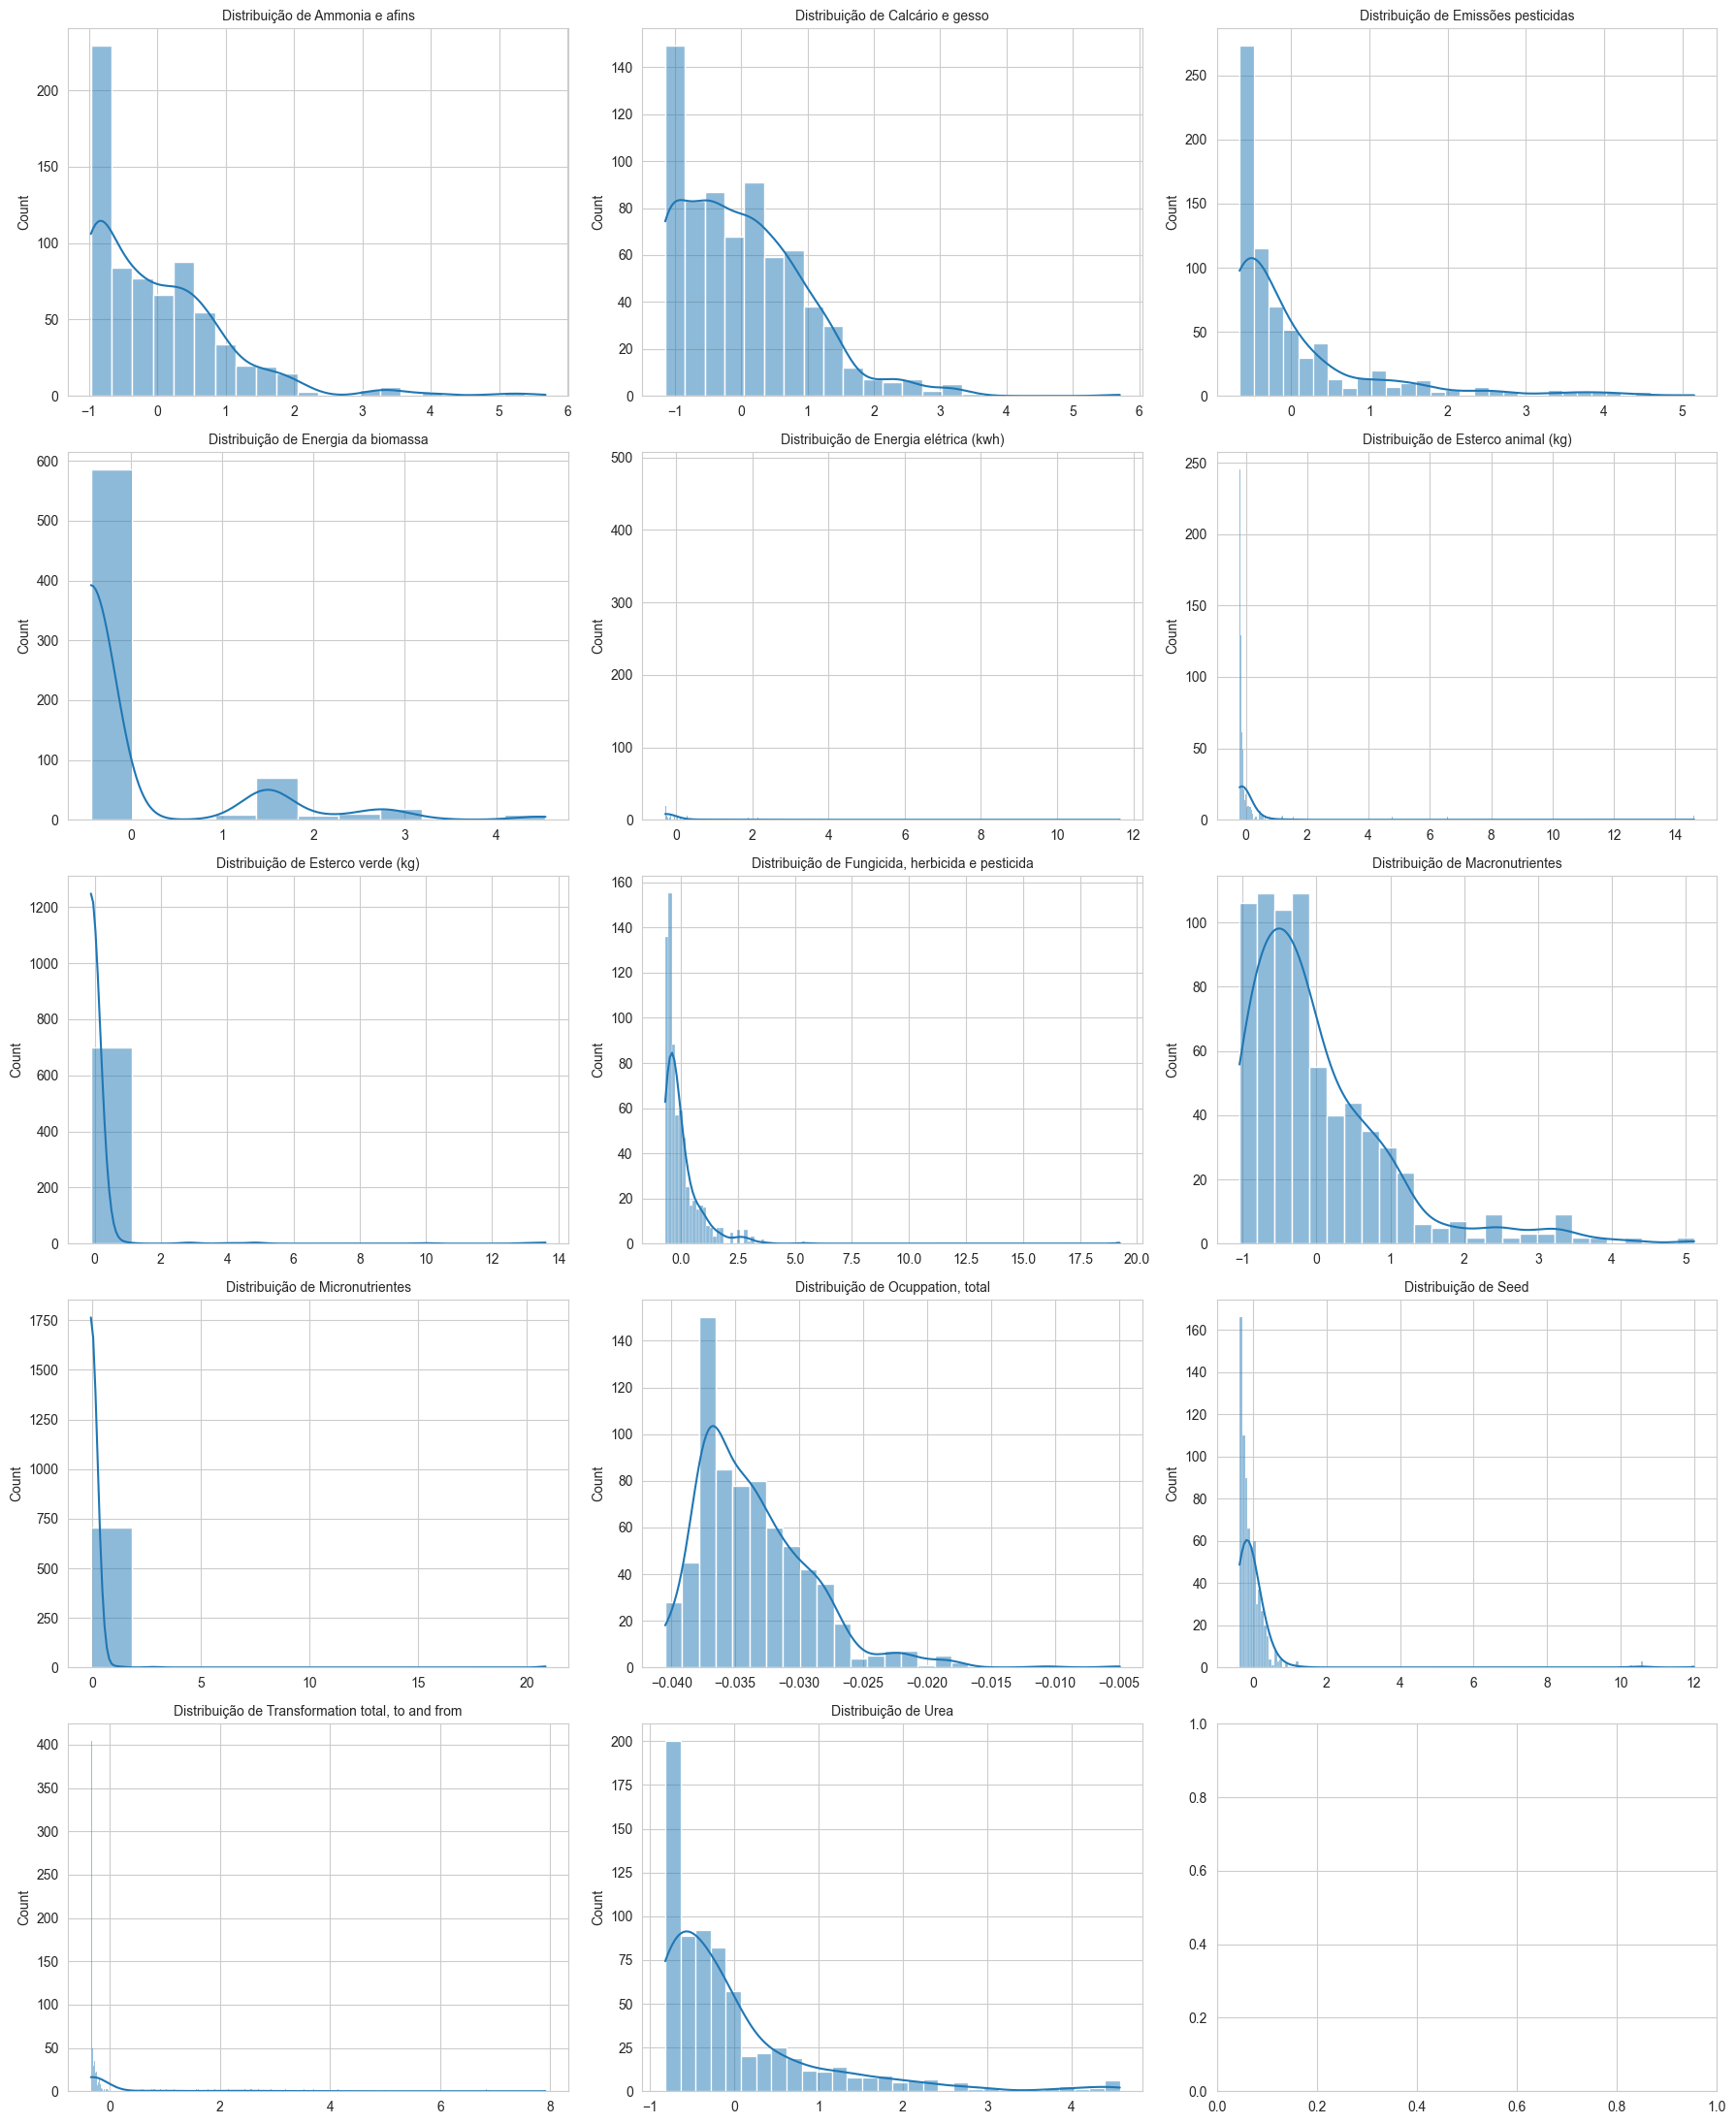

In [4]:
sns.set_style('whitegrid')

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 22))

ax = axes.flatten()
for i, col in enumerate(mapped_feature_columns):
    sns.histplot(
        data=train_mapped,
        x=col,
        ax=ax[i],
        kde=True 
    )
    ax[i].set_title(f'Distribuição de {col}', fontsize=10)
    ax[i].set_xlabel('') #Remove o rótulo do eixo x para não poluir


plt.tight_layout()
plt.show()


Feature Heat map

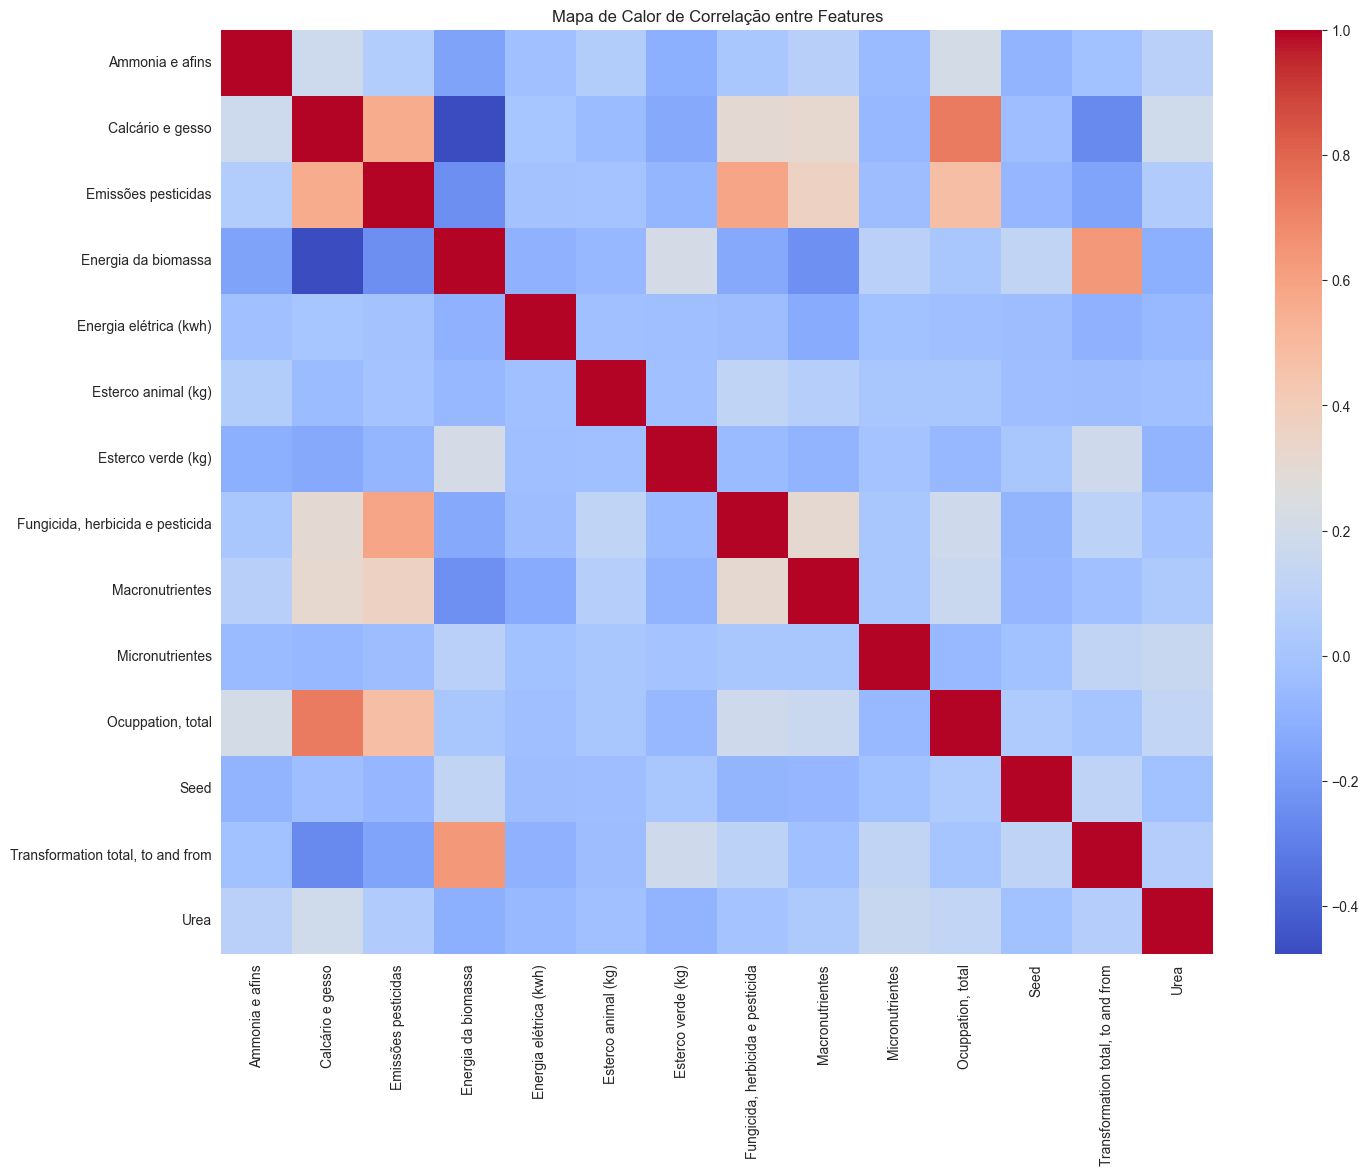

In [5]:
# Mapa de Calor de Correlação entre Features
corr_features = train_mapped[mapped_feature_columns].corr()


plt.figure(figsize=(16, 12))
sns.heatmap(corr_features, cmap='coolwarm', annot=False)
plt.title('Mapa de Calor de Correlação entre Features')
plt.show()

Target Heat Map

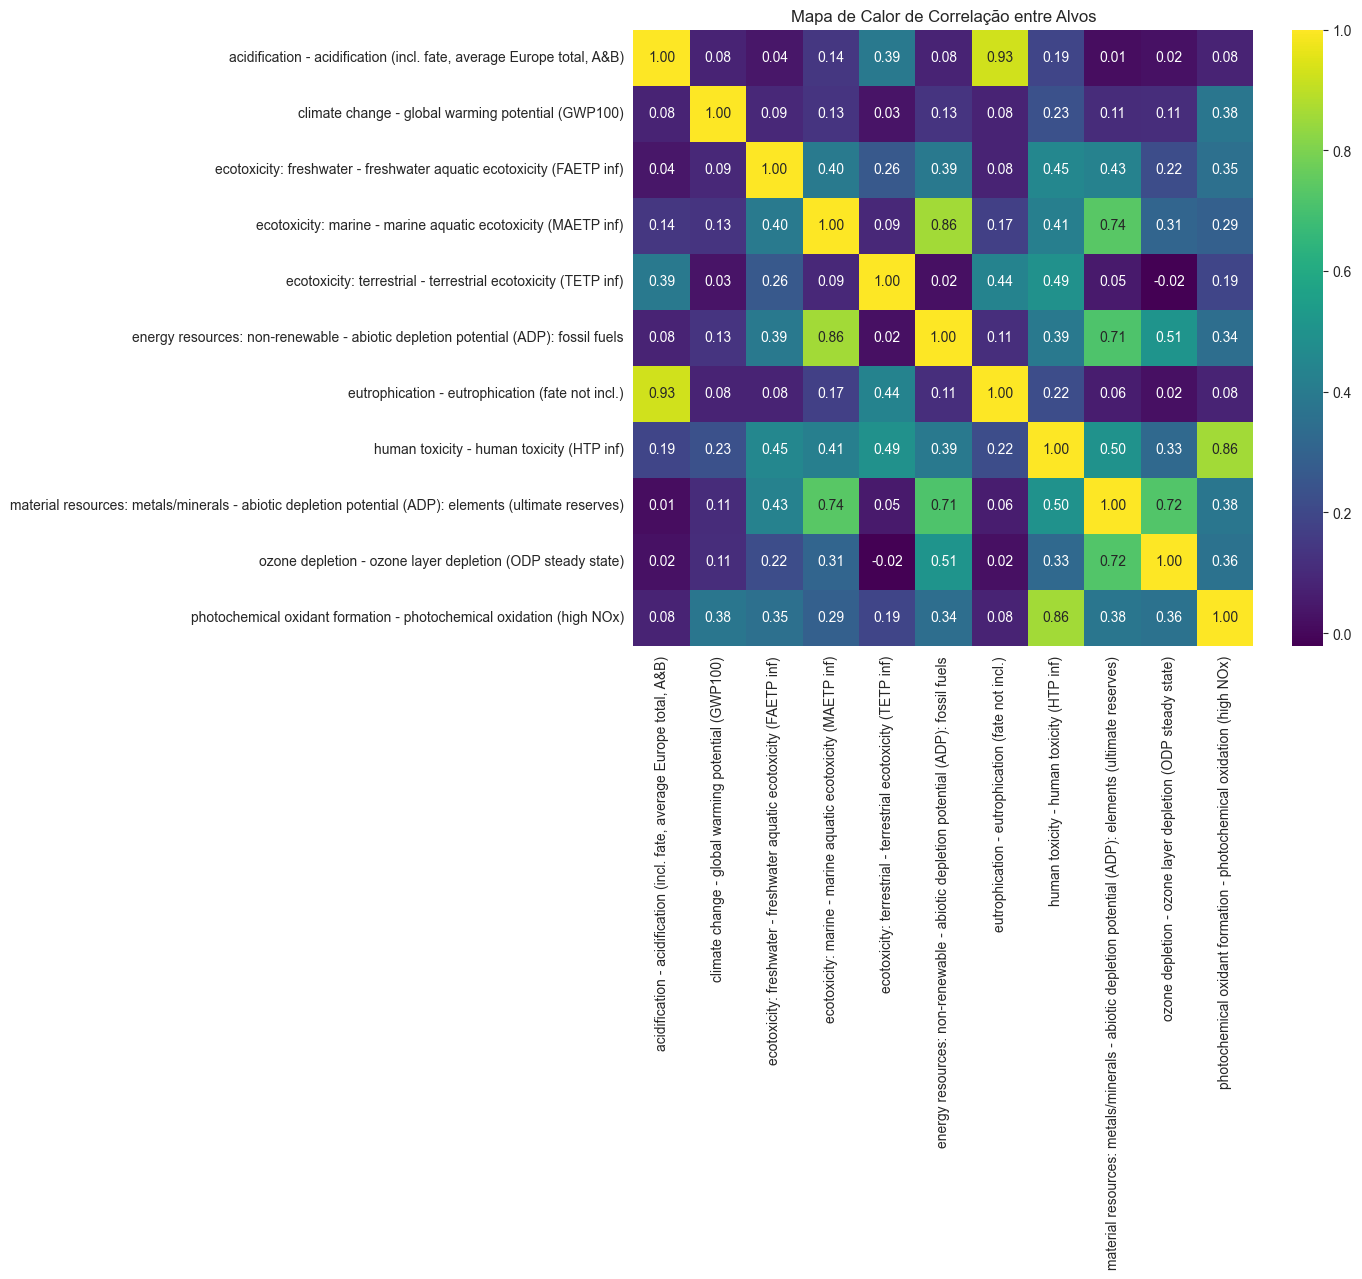

In [6]:
corr_targets = train_mapped[mapped_target_columns].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(corr_targets, cmap='viridis', annot=True, fmt='.2f')
plt.title('Mapa de Calor de Correlação entre Alvos')
plt.show()

Feature x Target

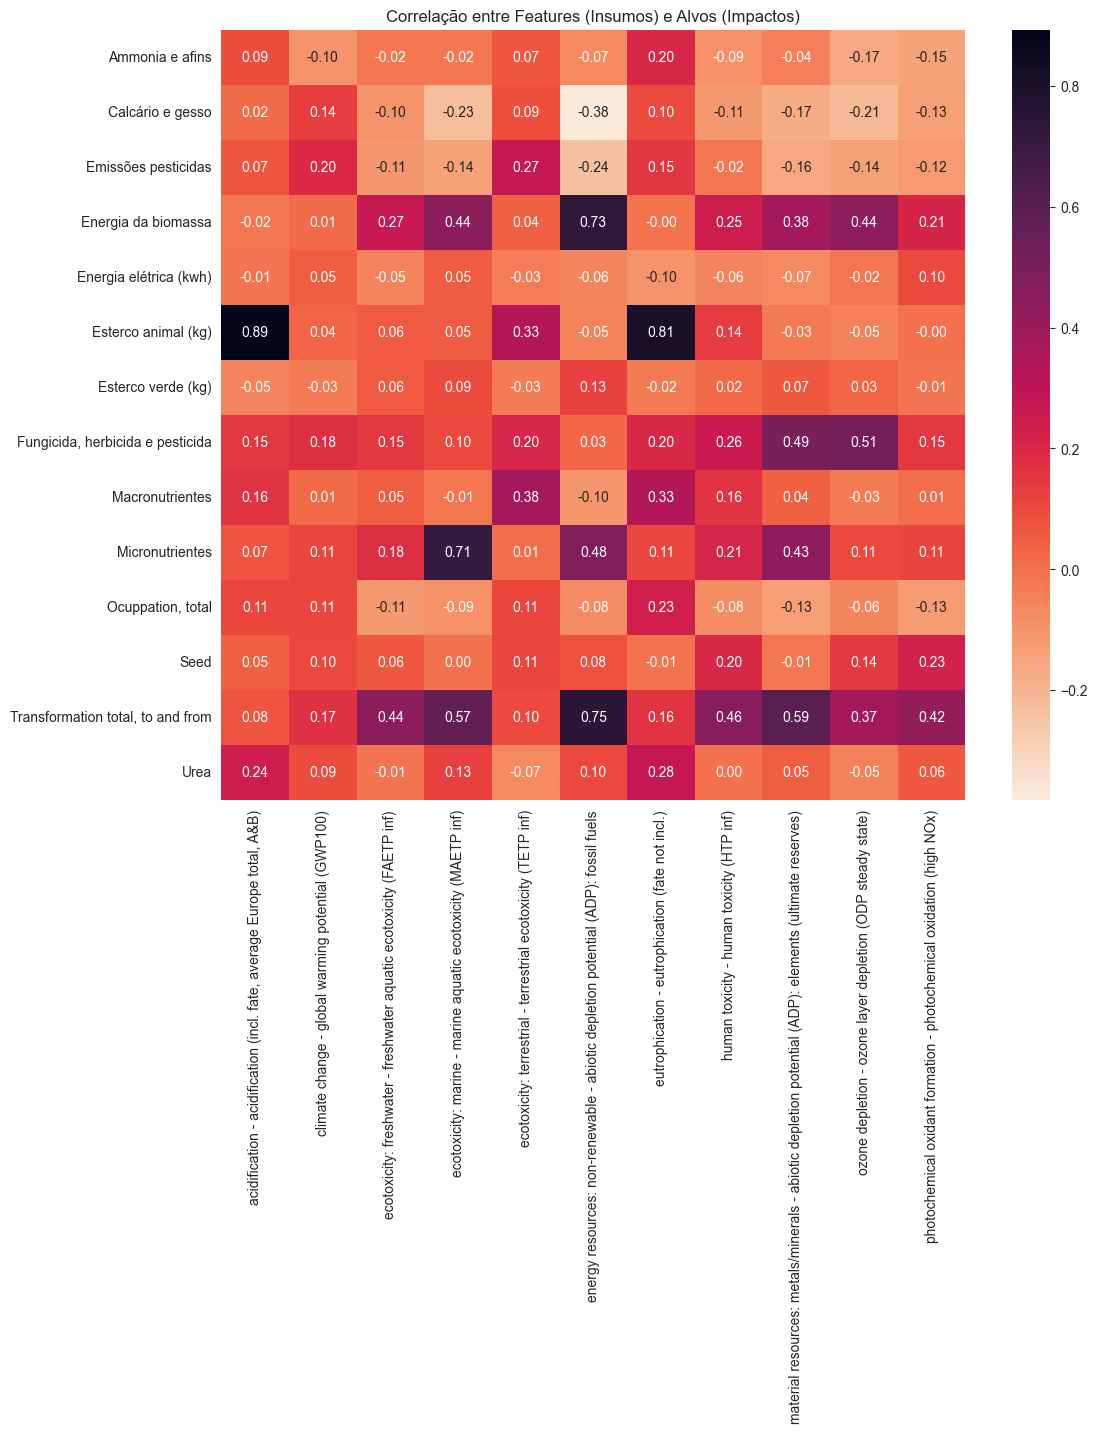

In [7]:
temp_df = train_mapped[mapped_feature_columns + mapped_target_columns]
corr_full = temp_df.corr()

# Selecionando apenas a parte que cruza features com alvos
corr_feat_target = corr_full.loc[mapped_feature_columns, mapped_target_columns]

plt.figure(figsize=(12, 10))
sns.heatmap(corr_feat_target, cmap='rocket_r', annot=True, fmt='.2f')
plt.title('Correlação entre Features (Insumos) e Alvos (Impactos)')
plt.show()

# Pré-processamento dos Dados

In [8]:
cols_to_drop = ['feature2', 'feature3', 'feature6', 'feature8']

numerical_features = [col for col in feature_columns if col not in cols_to_drop]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
    ]
)

# Modelagem e Treinamento

In [9]:
x = train[numerical_features]
y = train[target_columns]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

# Pipeline final
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, tree_method="hist")
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', MultiOutputRegressor(xgb))
])

model.fit(x_train, y_train)

y_pred = model.predict(x_val)
mse = mean_squared_error(y_val, y_pred)
print(f"MSE val: {mse:.4f}")

MSE val: 0.0987


# Submissão

In [10]:
test_preds = model.predict(test[numerical_features])

submission = pd.DataFrame(test_preds, 
                          columns=[f'target{i+1}' for i in range(11)])

submission.insert(0, 'Id', test['feature1'])

submission.to_csv('submission.csv', index=False)